# Chest Pneumonia Classify MONAI Pytorch


## What is MONAI?
https://github.com/Project-MONAI/MONAI
- MONAI is a PyTorch-based, open-source framework for deep learning in healthcare imaging, part of PyTorch Ecosystem. 
- flexible pre-processing for multi-dimensional medical imaging data;
- compositional & portable APIs for ease of integration in existing workflows;
- domain-specific implementations for networks, losses, evaluation metrics and more;
- customizable design for varying user expertise;
- multi-GPU data parallelism support.


## Install MONAI

In [1]:
!pip install -q "monai-weekly[gdown, nibabel, tqdm, itk]"

In [2]:
import os
import shutil
import tempfile
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
import torch
from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import *
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism

#print_config()

## Read image filenames from the dataset folders

In [3]:
train_dir = '../input/chest-xray-pneumonia/chest_xray/train/' 
test_dir = '../input/chest-xray-pneumonia/chest_xray/test/' 
val_dir = '../input/chest-xray-pneumonia/chest_xray/val/' 

class_names0 = sorted([x for x in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, x))])
class_names=['NORMAL', 'PNEUMONIA']

num_class = len(class_names)

image_files = [[os.path.join(train_dir, class_name, x) 
               for x in os.listdir(os.path.join(train_dir, class_name))] 
               for class_name in class_names]
test_image_files = [[os.path.join(test_dir, class_name, x) 
               for x in os.listdir(os.path.join(test_dir, class_name))] 
               for class_name in class_names]
val_image_files = [[os.path.join(val_dir, class_name, x) 
               for x in os.listdir(os.path.join(val_dir, class_name))] 
               for class_name in class_names]

print(class_names)

['NORMAL', 'PNEUMONIA']


In [4]:
image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)
print(image_file_list[0:10])

test_image_file_list = []
test_image_label_list = []
for i, class_name in enumerate(class_names):
    test_image_file_list.extend(test_image_files[i])
    test_image_label_list.extend([i] * len(test_image_files[i]))
test_num_total = len(test_image_label_list)
print(test_image_file_list[0:10])

val_image_file_list = []
val_image_label_list = []
for i, class_name in enumerate(class_names):
    val_image_file_list.extend(val_image_files[i])
    val_image_label_list.extend([i] * len(val_image_files[i]))
val_num_total = len(val_image_label_list)
print(val_image_file_list[0:10])

['../input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0771-0001.jpeg', '../input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1294-0001-0002.jpeg', '../input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0675-0001.jpeg', '../input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1169-0001.jpeg', '../input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0421-0001.jpeg', '../input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0531-0001.jpeg', '../input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0416-0001-0002.jpeg', '../input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0965-0001.jpeg', '../input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0627-0001.jpeg', '../input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0997-0001.jpeg']
['../input/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0336-0001.jpeg', '../input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0101-0001.jpeg', '../input/chest-xr

In [5]:
image_width, image_height = Image.open(image_file_list[0]).size

print('Total image count:', num_total)
print("Image dimensions:", image_width, "x", image_height)
print("Label names:", class_names)
print("Label counts:", [len(image_files[i]) for i in range(num_class)])

Total image count: 5216
Image dimensions: 1336 x 1128
Label names: ['NORMAL', 'PNEUMONIA']
Label counts: [1341, 3875]


## Visualise some examples

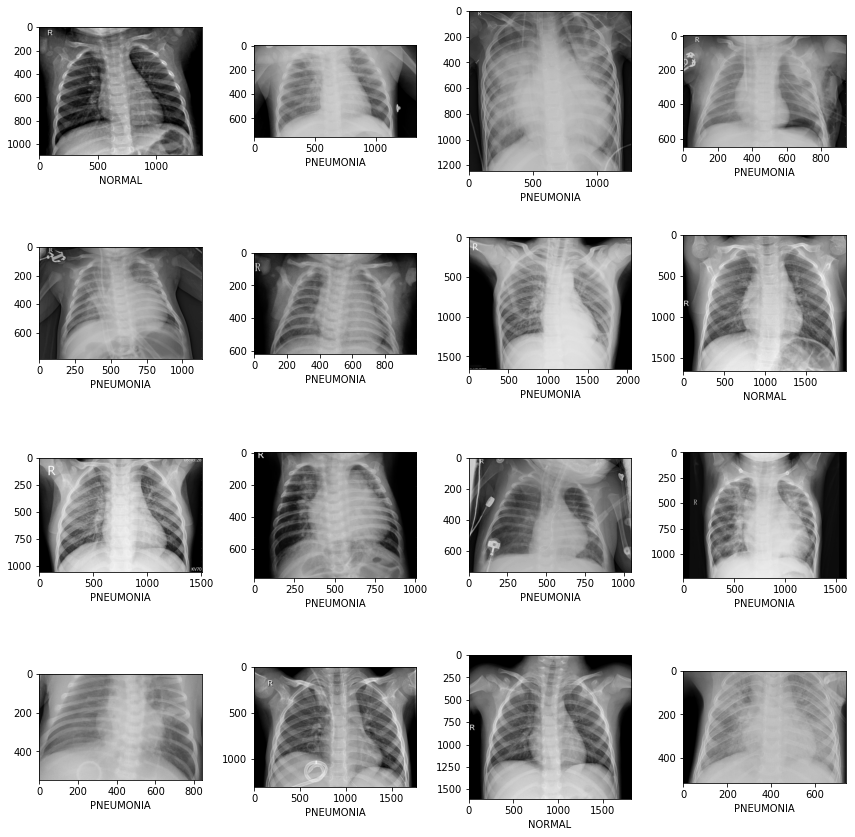

In [6]:
plt.subplots(4,4, figsize=(12,12))
for i,k in enumerate(np.random.randint(num_total, size=16)):
    im = Image.open(image_file_list[k])
    arr = np.array(im)
    plt.subplot(4,4, i + 1)
    plt.xlabel(class_names[image_label_list[k]])
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()

## Prepare training, validation and test data lists

In [7]:
#valid_frac, test_frac = 0.1, 0.1
trainX, trainY = [], []
valX, valY = [], []
testX, testY = [], []

#rann = np.random.random()
for i in range(val_num_total):
        valX.append(val_image_file_list[i])
        valY.append(val_image_label_list[i])
        
for i in range(test_num_total):
        testX.append(test_image_file_list[i])
        testY.append(test_image_label_list[i])
        
for i in range(num_total):
        trainX.append(image_file_list[i])
        trainY.append(image_label_list[i])

print(len(trainX),len(valX),len(testX))

5216 16 624


## Define MONAI transforms, Dataset and Dataloader to pre-process data

In [8]:
class MyResize(Transform):
    def __init__(self, size=(80,80)):  
        self.size = size
    def __call__(self, inputs):
        image2=cv2.resize(inputs,dsize=(self.size[1],self.size[0]),interpolation=cv2.INTER_CUBIC)
        return image2

In [9]:
train_transforms = Compose([
    LoadImage(image_only=True),
    Resize((-1,1)),
    ScaleIntensity(),
    MyResize(), 
    AddChannel(),    
    ToTensor()
])

val_transforms = Compose([
    LoadImage(image_only=True),
    Resize((-1,1)),
    ScaleIntensity(),
    MyResize(), 
    AddChannel(),    
    ToTensor()
])

test_transforms = Compose([
    LoadImage(image_only=True),
    Resize((-1,1)),
    ScaleIntensity(),
    MyResize(), 
    AddChannel(),    
    ToTensor()
])

act = Activations(softmax=True)
to_onehot = AsDiscrete(to_onehot=True, n_classes=num_class)

`to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.


In [10]:
class MedNISTDataset(Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms
    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

In [11]:
train_ds = MedNISTDataset(trainX, trainY, train_transforms)
train_loader = DataLoader(train_ds, batch_size=300, shuffle=True, num_workers=2)

val_ds = MedNISTDataset(valX, valY, val_transforms)
val_loader = DataLoader(val_ds, batch_size=300, num_workers=2)

test_ds = MedNISTDataset(testX, testY, test_transforms)
test_loader = DataLoader(test_ds, batch_size=300, num_workers=2)

## Define network and optimizer

- Sets the learning rate for the amount of model updates for each batch.
- There are shuffle and random transformations, so set the total number of epochs.
- Use MONAI's DenseNet.
- Use the Adam Optimizer.

In [12]:
device = torch.device("cuda:0")   # "cuda:0","cpu"
model = DenseNet121(
    spatial_dims=2,
    in_channels=1,
    out_channels=num_class
).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
epoch_num = 20
val_interval = 1

## Model training
- Perform common PyTorch training to perform epoch and step loops and validate each epoch.
- If you get the best validation accuracy, save the model weights to a file.

In [13]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
auc_metric = ROCAUCMetric()
metric_values = list()

for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:     #### error here
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [to_onehot(i) for i in y]
            y_pred_act = [act(i) for i in y_pred]
            auc_metric(y_pred_act, y_onehot)
            auc_result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(auc_result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            
            if acc_metric > best_metric:
                best_metric = acc_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'best_metric_model.pth')
                print('saved new best metric model')
                
            print(f"current epoch: {epoch + 1} current AUC: {auc_result:.4f}"
                  f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f}"
                  f" at epoch: {best_metric_epoch}")
            
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

----------
epoch 1/20
1/17, train_loss: 0.7202
2/17, train_loss: 0.7152
3/17, train_loss: 0.6965
4/17, train_loss: 0.6971
5/17, train_loss: 0.6584
6/17, train_loss: 0.6560
7/17, train_loss: 0.6461
8/17, train_loss: 0.6279
9/17, train_loss: 0.6190
10/17, train_loss: 0.6124
11/17, train_loss: 0.5974
12/17, train_loss: 0.6058
13/17, train_loss: 0.5875
14/17, train_loss: 0.5808
15/17, train_loss: 0.5613
16/17, train_loss: 0.5751
17/17, train_loss: 0.5494
18/17, train_loss: 0.5418
epoch 1 average loss: 0.6249
saved new best metric model
current epoch: 1 current AUC: 0.7188 current accuracy: 0.5000 best AUC: 0.5000 at epoch: 1
----------
epoch 2/20
1/17, train_loss: 0.5228
2/17, train_loss: 0.5215
3/17, train_loss: 0.5334
4/17, train_loss: 0.5178
5/17, train_loss: 0.5288
6/17, train_loss: 0.5133
7/17, train_loss: 0.5000
8/17, train_loss: 0.4715
9/17, train_loss: 0.4821
10/17, train_loss: 0.4774
11/17, train_loss: 0.4816
12/17, train_loss: 0.4868
13/17, train_loss: 0.4635
14/17, train_loss: 0

## Plot the loss and metric

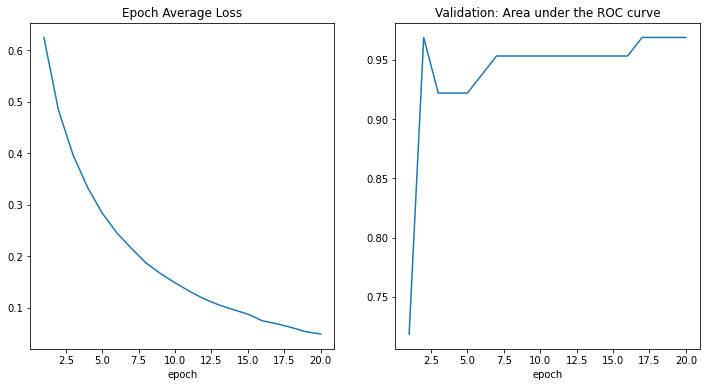

In [14]:
plt.figure('train', (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Validation: Area under the ROC curve")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.show()

## Evaluate the model on test dataset
- After training and verification, we have already obtained the best model in the verification test.
- You should evaluate your model in a test dataset to see if it is robust and overfitting.

In [15]:
model.load_state_dict(torch.load('best_metric_model.pth'))
model.eval()
y_true = list()
y_pred = list()
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [16]:
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

      NORMAL     0.8528    0.5940    0.7003       234
   PNEUMONIA     0.7939    0.9385    0.8602       390

    accuracy                         0.8093       624
   macro avg     0.8233    0.7662    0.7802       624
weighted avg     0.8160    0.8093    0.8002       624

